In [80]:
#最終的にまとめたCSVファイルから情報を抜き出し、降水域の線のみプロットさせる。
#pklだと上が見切れたのでそのまま透過画像を張り付ける形に

In [83]:
#ここから流れを整理したもの

In [103]:
#東北の地図作成
#描画ベースの地図作成
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

# 地図の範囲
#日本全体
#lat_min, lat_max = 20.0, 50.0
#lon_min, lon_max = 120.0, 150.0

#東北
lat_min, lat_max = 36.0, 44.0
lon_min, lon_max = 136.0, 145.0

# 描画用のFigureとAxes（PlateCarreeで緯度経度座標）
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 陸地・海を描画
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='white')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='white')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)

# 県境（都道府県境）を追加
# scale: '10m' / '50m' / '110m' の中で '10m' が最も詳細
admin1 = NaturalEarthFeature(category='cultural',
                              name='admin_1_states_provinces_lines',
                              scale='10m',
                              facecolor='none',
                              edgecolor='black',  # 線の色
                              linewidth=0.5)

ax.add_feature(admin1)

# 緯度経度のグリッド線
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# 背景地図を保存（透過PNGでもOK）
plt.savefig("pkl/add/100-80_ratio25/map_tohoku.png", bbox_inches='tight', dpi=150)
plt.close()


In [87]:
#まず抽出時に出力される画像から降水域の外周の黒線のみを抜き出し、透過画像に落とし込む
#余白追加var
import pandas as pd
import calendar
import cv2
import numpy as np
import pickle
import os

csvdir = '/mnt/jet12/makoto/extract_senjo/ext_sun/csv/100-80/total_4-10_2021-2024_ratio2.0_onlytohok.csv'
df = pd.read_csv(csvdir, dtype={'dtst': str, 'dten': str, 'ID': str, 'hrid': str, 'angle' : str, 'lat' : str, 'lon':str})

pkl_dir = 'pkl/add/100-80_ratio25/'
os.makedirs(pkl_dir, exist_ok=True)

for index, row in df.iterrows():
    dtst = row["dtst"]
    hrid = row["hrid"]

    YYYYMM = dtst[:6]
    YYYY = int(YYYYMM[:4])
    MM = int(YYYYMM[4:6])
    DD = calendar.monthrange(YYYY, MM)[1]
    MM_str = f"{MM:02d}"

    pngdir = f'/mnt/jet12/makoto/extract_senjo/ext_sun/bin/09ra_contribution/png/{YYYY}{MM_str}01-{MM_str}{DD:02d}/heavyrainfall_{hrid}.png'
    img = cv2.imread(pngdir)
    if img is None:
        print(f"画像が読み込めません: {pngdir}")
        continue

    # トリミング
    trim_top, trim_bottom, trim_left, trim_right = 68, 130, 20, 80
    h, w = img.shape[:2]
    img = img[trim_top:h-trim_bottom, trim_left:w-trim_right]

    # グレースケール化 & 黒抽出
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # 輪郭抽出
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 長さでフィルタリング
    min_length = 100
    filtered_contours = [cnt for cnt in contours if max(cv2.boundingRect(cnt)[2:]) >= min_length]

    # --- 余白追加 ---
    # 余白ピクセル数
    pad = 20
    new_h, new_w = mask.shape[0] + 2*pad, mask.shape[1] + 2*pad
    contours_padded = []
    for cnt in filtered_contours:
        cnt_shifted = cnt + [pad, pad]  # x, y両方にpadを足す
        contours_padded.append(cnt_shifted)

    # --- PNG 保存 ---
    output_rgba = np.zeros((new_h, new_w, 4), dtype=np.uint8)
    for cnt in contours_padded:
        cv2.drawContours(output_rgba, [cnt], -1, (0,0,0,255), thickness=2)
    pngout = os.path.join(pkl_dir, f"{hrid}.png")
    cv2.imwrite(pngout, output_rgba)

    print(f"{hrid}: 抽出した輪郭数 = {len(filtered_contours)}（余白付加後保存）")

HR00179: 抽出した輪郭数 = 1（余白付加後保存）
HR00182: 抽出した輪郭数 = 1（余白付加後保存）
HR00185: 抽出した輪郭数 = 1（余白付加後保存）
HR00035: 抽出した輪郭数 = 1（余白付加後保存）
HR00083: 抽出した輪郭数 = 1（余白付加後保存）
HR00096: 抽出した輪郭数 = 1（余白付加後保存）
HR00101: 抽出した輪郭数 = 1（余白付加後保存）


In [101]:
#この時に線の太さを変えたり、走行に応じて色分けを行った上で新しい透過画像作成
from PIL import Image, ImageDraw
import pandas as pd
import os

# CSV読み込み
csvdir = '/mnt/jet12/makoto/extract_senjo/ext_sun/csv/100-80/total_4-10_2021-2024_ratio2.0_onlytohok.csv'
df = pd.read_csv(csvdir, usecols=["hrid", "angle"])

pkl_dir = 'pkl/add/100-80_ratio25/'
os.makedirs(pkl_dir, exist_ok=True)

# RGB色定義（0〜255に直す）
colors = {
    "blue": (0, 0, 254, 255),
    "green": (0, 168, 0, 255),
    "yellow": (255, 178, 0, 255),
    "red": (254, 0, 0, 255)
}

# 角度に応じて色を返す関数
def colorjudge(angle):
    if (337.5 <= angle <= 360.0) or (157.5 <= angle < 202.5) or (0 <= angle < 22.5):
        return colors["blue"]
    elif (22.5 <= angle < 67.5) or (202.5 <= angle < 247.5):
        return colors["green"]
    elif (67.5 <= angle < 112.5) or (247.5 <= angle < 292.5):
        return colors["yellow"]
    else:
        return colors["red"]


# 元の透過PNG画像があるディレクトリ
src_dir = "pkl/add/100-80_ratio25/"

for idx, row in df.iterrows():
    ID = row["hrid"]
    angle = row["angle"]

    img_path = os.path.join(src_dir, f"{ID}.png")
    if not os.path.exists(img_path):
        print("no file")
        continue  # ファイルがなければスキップ

    # 元画像読み込み
    img = Image.open(img_path).convert("RGBA")
    w, h = img.size

    # 描画用レイヤー
    overlay = Image.new("RGBA", img.size, (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    # 元画像の輪郭部分（黒）のピクセルを取得
    pixels = img.load()
    for y in range(h):
        for x in range(w):
            if pixels[x, y][0:3] == (0, 0, 0) and pixels[x, y][3] > 0:
                draw.point((x, y), fill=colorjudge(angle))

    # 線を太くしたい場合は、ぼかす代わりに近傍に点を追加
    # 例: 1ピクセル拡張
    thick_overlay = Image.new("RGBA", img.size, (0,0,0,0))
    thick_draw = ImageDraw.Draw(thick_overlay)
    for y in range(h):
        for x in range(w):
            if overlay.getpixel((x,y))[3] > 0:
                for dx in [-2,-1,0,1,2]:
                    for dy in [-2,-1,0,1,2]:
                        nx, ny = x+dx, y+dy
                        if 0 <= nx < w and 0 <= ny < h:
                            thick_draw.point((nx, ny), fill=overlay.getpixel((x,y)))

    # 保存
    thick_overlay.save(os.path.join(pkl_dir, f"{ID}_color.png"))

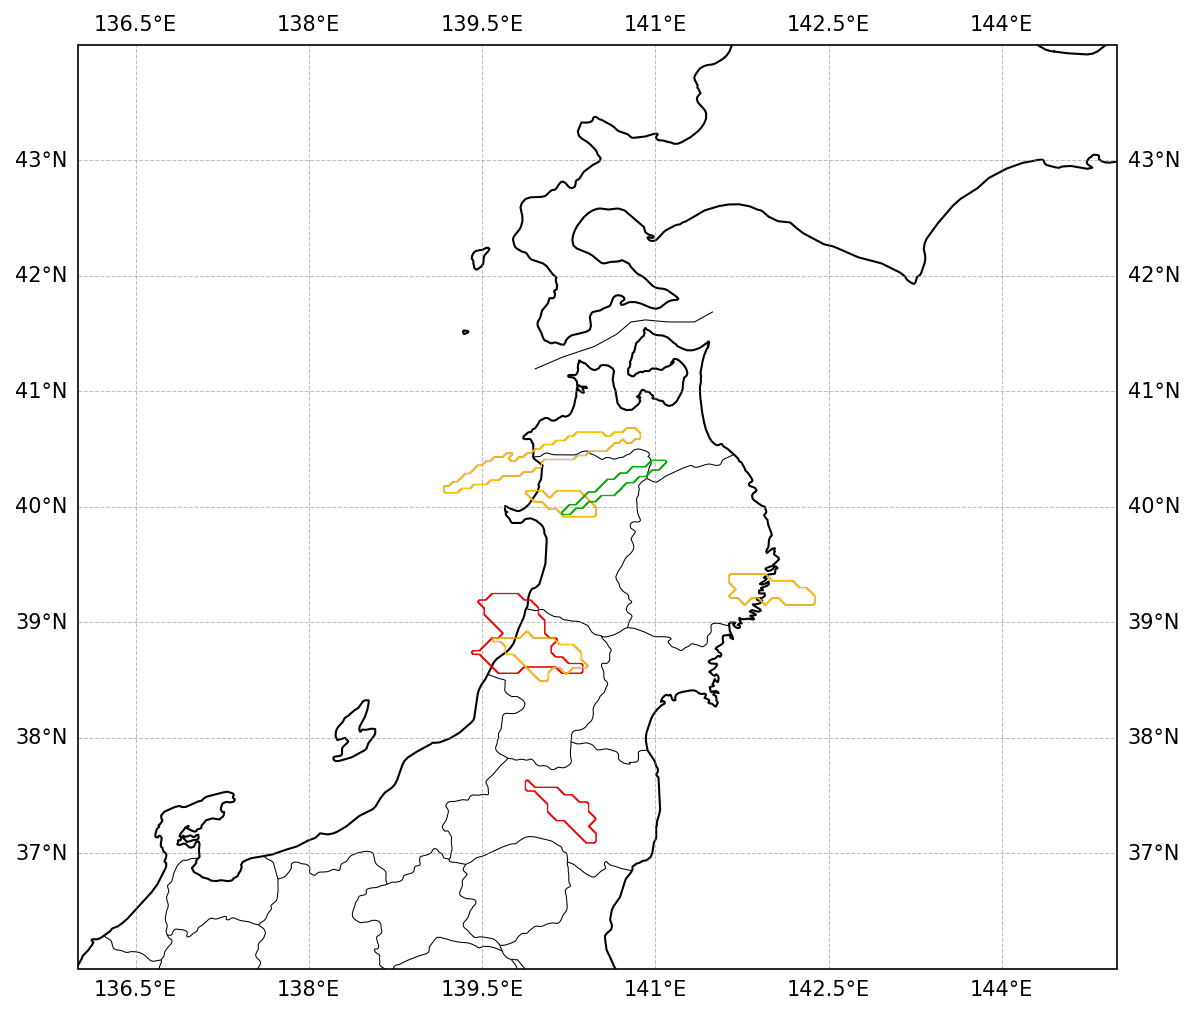

In [104]:
#張り付ける
#位置は適宜チェックしてずらす
from PIL import Image

# ① 緯度経度→ピクセル座標関数を追加
def latlon_to_pixel(lat, lon, lat_min, lat_max, lon_min, lon_max, width, height):
    x = int((lon - lon_min) / (lon_max - lon_min) * width)
    y = int((lat_max - lat) / (lat_max - lat_min) * height)
    return x, y

# 背景キャンバス作成
#width, height = 1000, 800
#canvas = Image.new("RGBA", (width, height), (0, 0, 0, 0))

canvas = Image.open("pkl/add/100-80_ratio25/map_tohoku.png").convert("RGBA")
width, height = canvas.size


# 緯度経度範囲
lat_min, lat_max = 36.0, 44.0
lon_min, lon_max = 136.0, 145.0

#ID lat lonを読ませる
csvdir = '/mnt/jet12/makoto/extract_senjo/ext_sun/csv/100-80/total_4-10_2021-2024_ratio2.0_onlytohok.csv'
df = pd.read_csv(csvdir, dtype={'dtst': str, 'dten': str, 'ID': str, 'hrid': str, 'angle' : str, 'lat' : str, 'lon':str})

pkl_dir = 'pkl/add/100-80_ratio25/'
os.makedirs(pkl_dir, exist_ok=True)

for index, row in df.iterrows():
    df = pd.read_csv(csvdir, dtype={'dtst': str, 'dten': str, 'ID': str, 'hrid': str, 'angle' : str})
# lat, lon は自動で float に変換される

#    dtst = row["dtst"]
#    hrid = row["hrid"]
#    lat  = row["lat"]
#    lon  = row["lon"]


# 貼り付ける画像と中心座標
#ひとまず先に書いて様子をみて適宜中心位置を変えて元画像と比較して適合するようにする
#images_to_paste = [
#    ("pkl/add/100-80_ratio25/HR00179.png", (39.0, 139.94)),
#    ("pkl/add/100-80_ratio25/HR00083.png", (40.35, 139.85)),
#]

#リストからループ
# CSVから列をリスト化
lat_list = df["lat"].tolist()
lon_list = df["lon"].tolist()
hrid_list = df["hrid"].tolist()

# リスト内包表記で images_to_paste を作成
images_to_paste = [
    (f"pkl/add/100-80_ratio25/{hrid}_color.png", (lat, lon))
    for hrid, lat, lon in zip(hrid_list, lat_list, lon_list)
]

#微調整したいもののみ後からうわがき
#images_to_paste[0] = (images_to_paste[0][0], (lat_list[0]+0.1, lon_list[0]-0.05))


#scale
scale = 0.25

for img_path, latlon in images_to_paste:
    overlay = Image.open(img_path).convert("RGBA")
    w, h = overlay.size

    # サイズを縮小
#    overlay = overlay.resize((int(w*scale), int(h*scale)), Image.ANTIALIAS)
    overlay = overlay.resize(
    (int(w*scale), int(h*scale)),
    resample=Image.Resampling.LANCZOS
)
    
    w, h = overlay.size  # 更新後のサイズ

    # 緯度経度 → ピクセル
    cx, cy = latlon_to_pixel(latlon[0], latlon[1], lat_min, lat_max, lon_min, lon_max, width, height)
    
    # 中心座標から左上座標を計算
    top_left = (cx - w // 2, cy - h // 2)

    # 貼り付け
    temp = Image.new("RGBA", canvas.size, (0,0,0,0))
    temp.paste(overlay, top_left, overlay)
    canvas = Image.alpha_composite(canvas, temp)

canvas.save("pkl/add/100-80_ratio25/result_map.png")

from IPython.display import display
display(canvas)